In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [109]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [110]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [205]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
C = torch.randn((27,2))

In [28]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [29]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [56]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [59]:
h

tensor([[ 1.0000, -0.2416,  0.8126,  ..., -0.9494,  0.9976, -0.6830],
        [ 1.0000, -0.9439,  0.9980,  ..., -0.9822,  0.9774, -0.4339],
        [ 0.6651,  0.9999, -0.4602,  ..., -0.9998,  1.0000,  0.7313],
        ...,
        [ 0.9994, -0.7150,  0.9976,  ...,  0.9994, -0.9884,  0.1639],
        [ 0.9969,  0.9981, -0.6774,  ..., -0.8347,  0.9803, -0.3387],
        [ 1.0000, -0.9080,  0.9977,  ..., -0.6951,  0.8455, -0.6162]])

In [60]:
h.shape

torch.Size([32, 100])

In [63]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [64]:
logits = h @ W2 + b2

In [65]:
logits.shape

torch.Size([32, 27])

In [66]:
counts = logits.exp()

In [71]:
prob = counts / counts.sum(1, keepdims=True)

In [72]:
prob.shape

torch.Size([32, 27])

In [76]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(22.0996)

In [74]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [210]:
# ---------- now made more respectable :) ----------  
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [273]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [274]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [275]:
for p in parameters:
    p.requires_grad = True

In [259]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [276]:
lri = []
lossi = []
stepi = []

In [277]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print(loss.item())

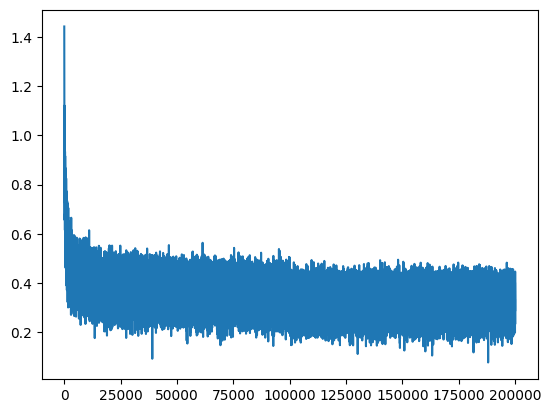

In [278]:
plt.plot(stepi, lossi)

In [279]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1217, grad_fn=<NllLossBackward0>)

In [280]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1620, grad_fn=<NllLossBackward0>)

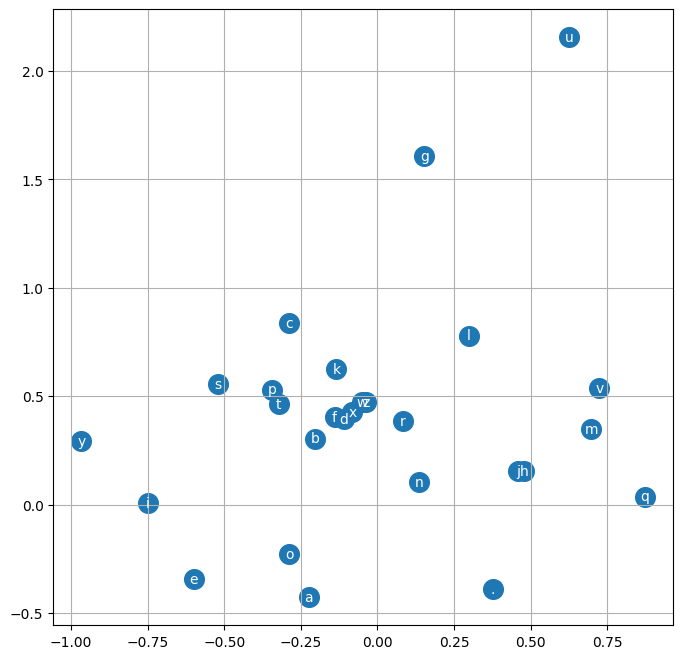

In [255]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [286]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 - 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

navia.
edyn.
keyn.
rah.
tatyn.
lesemarnav.
marchanoz.
ethees.
kami.
bryttepelpena.
kayleno.
zihonder.
alee.
siah.
dalie.
srey.
chrisha.
shaela.
pariyanett.
raylyn.
